In [2]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy as np 
import warnings
import fresnel
import IPython
import packaging.version 
import matplotlib
import io 
import PIL
import freud
import matplotlib.pyplot as plt 

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [3]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    vertices = [
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)

    geometry = fresnel.geometry.Polygon(
        scene, vertices = vertices, N=len(snapshot.particles.position)
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([100 / 255, 216 / 255, 230 / 255]), roughness=0.2
    )
    positions = np.array(snapshot.particles.position)[:, :2]
    geometry.position[:] = positions

    orientations = np.array(snapshot.particles.orientation)
    angles = 2 * np.arctan2(orientations[:, 3], orientations[:, 0])
    geometry.angle[:] = angles
    
    geometry.outline_width = 0.01

    fresnel.geometry.Box(scene, [L, L, 0.1, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(0, 0, 10), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    samples = 2000
    if "CI" in os.environ:
        samples = 100
    return tracer.sample(scene, samples=samples)

In [4]:
def render_movie(frames):
    a = render(frames[0])
    im0 = PIL.Image.fromarray(a[:, :, 0:3], mode="RGB").convert(
        "P", palette=PIL.Image.Palette.ADAPTIVE
    )
    ims = []
    for i, f in enumerate(frames[1:]):
        a = render(f)
        im = PIL.Image.fromarray(a[:, :, 0:3], mode="RGB")
        im_p = im.quantize(palette=im0)
        ims.append(im_p)

    blank = np.ones(shape=(im.height, im.width, 3), dtype=np.uint8) * 255
    im = PIL.Image.fromarray(blank, mode="RGB")
    im_p = im.quantize(palette=im0)
    ims.append(im_p)

    f = io.BytesIO()
    im0.save(f, "gif", save_all=True, append_images=ims, duration=1000, loop=0)

    size = len(f.getbuffer()) / 1024
    if size > 3000:
        warnings.warn(f"Large GIF: {size} KiB")
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [9]:
traj = gsd.hoomd.open('trajectory_cmp25.gsd')

In [13]:
len(traj)

100

In [ ]:
render_movie(traj[0::9])

In [7]:
solid = freud.order.SolidLiquid(l=6, q_threshold=0.7, solid_threshold=6)
is_solid = []
for frame in traj:
    solid.compute(
        system=(frame.configuration.box, frame.particles.position),
        neighbors=dict(mode="nearest", num_neighbors=8),
    )
    is_solid.append(solid.num_connections > solid.solid_threshold)

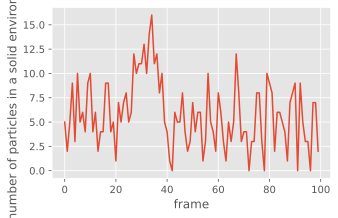

In [11]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
num_solid = np.array([np.sum(a) for a in is_solid])
ax.plot(num_solid)
ax.set_xlabel("frame")
ax.set_ylabel("number of particles in a solid environment")
fig